# Galaxia: Generating synthetic surveys

## Parameters/outputs: 

For files named test1_*, they are contained in the file $\texttt{test1parameters}$, which is located in the /u/casey_lam/scratch directory on sloop. In particular, we try to get all stars (so magnitude limits are -1000 to 1000), we want a full sky survey (so geometryOption is set to 0), and fSample is 10${}^{-6}$ such that the computer doesn't become stupid slow. 

For files named testLOS_*, they are contained in the file $\texttt{testLOSparameters}$, which is also located in /u/casey_lam/scratch. Here, we are considering the line of sight to a particular OGLE event. Again we want all stars, so magnitude limits are -1000 to 1000, the patch of sky is OGLE's field of view (35' x 35' = 0.34 deg${}^2$) so the surveyArea is set to 0.34. (The first time I ran this, I left fSample = 1 since I figured it wouldn't be that many stars... it ended up making 155 million stars, so I reran it with an fSample = 10${}^{-4}$.)

The relevant outputs are 3D position, proper motions, and brightness at several particular filters (probably R and K band.)

## Calculating observables from nonobservables

Galaxia gives positions and velocities in terms of Cartesian coordinates, centered at the Sun, but we want to get observables (proper motion, transverse velocities, and radial velocities) from that. I couldn't find a way to do it on Astropy, or some general formula on a website. It might (probably) be because of my subpar googling skills, but it was an opportunity to play with some equations. So here goes. Warning: very pedantic.

We are given positions and velocities in Cartesian coordinates
\begin{equation}
    \vec{r} = (x, y, z), \quad \vec{v} = (v_x, v_y, v_z).
\end{equation}

The velocity can be broken up into two pieces, a transverse and radial piece,
\begin{equation}
    \vec{v} = \vec{v}_T + \vec{v}_R.
\end{equation}

The radial velocity $\vec{v}_R$ is the velocity in the direction of our line of sight, while the transverse velocity $\vec{v}_T$ is perpendicular to the line of sight. To calculate the radial velocity, we take the projection of the velocity vector onto the position vector, i.e. the dot product, in the radial direction
\begin{equation}
    \vec{v}_R = (\vec{v} \cdot \hat{r}) \hat{r}
\end{equation}
where 
\begin{equation}
    \hat{r} \equiv \frac{\vec{r}}{|\vec{r}|} \equiv \frac{\vec{r}}{r}.
\end{equation}

Additionally, 
\begin{equation}
    v_T = 4.74 \mu r
\end{equation}
where $\vec{v}_T$ is in km/s, $\mu$ is in mas/year, and $r$ is in kpc. 

Putting this all together, the proper motion in mas/year is
\begin{equation}
    \mu = \frac{|\vec{v} - (\vec{v} \cdot \hat{r}) \hat{r}|}{4.74r}
\end{equation}
where velocities are in km/s and distances are in kpc.

The factor of 4.74 comes from all the conversions. Actually I found conflicting units/constants for the equation $v_T = 4.74 \mu r$ on the internet, so let's be careful and verify:

Converting milliarcseconds to radians: 
\begin{equation}
    1 mas = 10^{-3} as = 10^{-3} \frac{rad}{206265} 
\end{equation}

Converting kpc to km:
\begin{equation}
    1 kpc = 10^3 pc = 10^3 \times 206265 AU  = 10^3 \times 206265 \times 1.496 \times 10^8 km
\end{equation}

And there are $365.25 \times 24 \times 3600$ seconds in a year. So then

\begin{equation}
    \frac{mas}{year} =\frac{10^{-3}}{206265} \times 10^3 \times 206265 \times 1.496 \times 10^8 km / [365.25 \times 24 \times 3600 s] = 4.74 \frac{km}{s}.
\end{equation}

Hooray! We have the right constant. 
## Average proper motion and Velocity Dispersion

We calculate the average proper motion and velocity dispersion, as a function of distance from the Sun (HC coordinates) in mas/year.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import astropy.units as u
import astropy.coordinates as coord

In [2]:
#load px, py, pz (cartesian heliocentric positions) 
HCx = np.loadtxt("test1_px") #kpc
HCy = np.loadtxt("test1_py") #kpc
HCz = np.loadtxt("test1_pz") #kpc

#load vx, vy, vz (cartesian heliocentric velocities) 
HCxvel = np.loadtxt("test1_vx") #km/s
HCyvel = np.loadtxt("test1_vy") #km/s
HCzvel = np.loadtxt("test1_vz") #km/s

In [3]:
#calculate the magnitude of the velocity and position vector in HC coordinates
HCvel = []
for i in np.arange(len(HCxvel)):
    HCvel.append(np.sqrt(HCxvel[i]**2 + HCyvel[i]**2 + HCzvel[i]**2))
HCvel = np.array(HCvel)

HCradius = []
for i in np.arange(len(HCx)):
    HCradius.append(np.sqrt(HCx[i]**2 + HCy[i]**2 + HCz[i]**2))
HCradius = np.array(HCradius)

# Calculation of Proper Motion

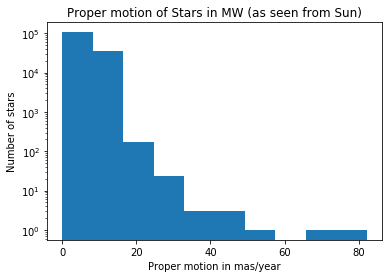

In [4]:
HCvelvec = np.array([HCxvel, HCyvel, HCzvel])
HCposvec = np.array([HCx, HCy, HCz])
vDOTr = (HCxvel*HCx + HCyvel*HCy + HCzvel*HCz)/(HCradius)
rHAT = HCposvec/HCradius
propermotion = np.linalg.norm(HCvelvec - vDOTr*rHAT, axis = 0)/(4.74 * HCradius)

plt.hist(propermotion)
plt.ylabel("Number of stars")
plt.xlabel("Proper motion in mas/year")
plt.yscale('log')
plt.title("Proper motion of Stars in MW (as seen from Sun)")
plt.show()

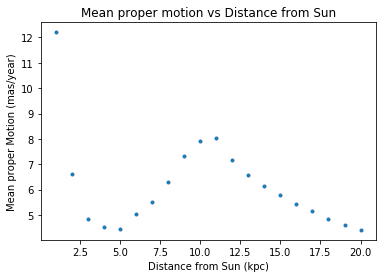

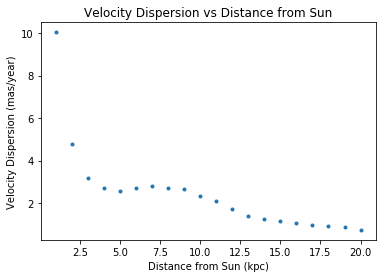

In [5]:
#calculate average proper motion and velocity dispersion as a function of distance from the Sun
HCvelvec = np.array([HCxvel, HCyvel, HCzvel])
HCposvec = np.array([HCx, HCy, HCz])
vDOTr = (HCxvel*HCx + HCyvel*HCy + HCzvel*HCz)/(HCradius)
rHAT = HCposvec/HCradius
allpropermotion = np.linalg.norm(HCvelvec - vDOTr*rHAT, axis = 0)/(4.74 * HCradius)

averagemotion = [[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]]
veldispersion = [[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]]
for i in np.arange(20):
    propermotions = allpropermotion[(HCradius > i) & (HCradius <= i + 1)]
    averagemotion[i] = np.mean(propermotions)
    veldispersion[i] = np.std(propermotions)
radialdist = np.arange(1,21)

plt.plot(radialdist, averagemotion, '.')
plt.xlabel("Distance from Sun (kpc)")
plt.ylabel("Mean proper Motion (mas/year)")
plt.title("Mean proper motion vs Distance from Sun")
plt.show()

plt.plot(radialdist, veldispersion, '.')
plt.xlabel("Distance from Sun (kpc)")
plt.ylabel("Velocity Dispersion (mas/year)")
plt.title("Velocity Dispersion vs Distance from Sun")
plt.show()

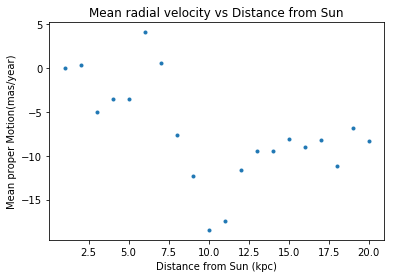

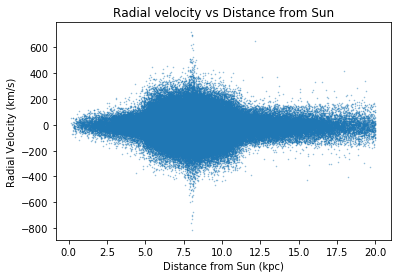

In [6]:
HCvelvec = np.array([HCxvel, HCyvel, HCzvel])
HCposvec = np.array([HCx, HCy, HCz])
vDOTr = (HCxvel*HCx + HCyvel*HCy + HCzvel*HCz)/(HCradius)

#calculate radial velocity as a function of distance from the Sun
dataarray = [[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]]
for i in np.arange(20):
    radialvel = vDOTr[(HCradius > i) & (HCradius <= i + 1)]
    dataarray[i] = np.mean(radialvel)
radialdist = np.arange(1,21)
plt.plot(radialdist, dataarray, '.')
plt.xlabel("Distance from Sun (kpc)")
plt.ylabel("Mean proper Motion(mas/year)")
plt.title("Mean radial velocity vs Distance from Sun")
plt.show()

radiusvec = []
radvelvec = []
for i in np.arange(len(HCradius)):
    if HCradius[i] < 20:
        radiusvec.append(HCradius[i])
        radvelvec.append(vDOTr[i])
radiusvec = np.array(radiusvec)
radvelvec = np.array(radvelvec)
plt.plot(radiusvec, radvelvec, '.', alpha=0.5, ms=1)
plt.xlabel("Distance from Sun (kpc)")
plt.ylabel("Radial Velocity (km/s)")
plt.title("Radial velocity vs Distance from Sun")
plt.show()

Just a note to myself: although km/s and mas/year are both measures of motion, they aren't equivalent! Consider the plots below, which describe the distribution of velocities of stars in km/s. They aren't the same shape as the plots when the units are in mas/year! That's because when you describe angular motion, you are considering the motion in projection, and it is dependent on how far away from the object you're observing! The proper motion we observe of a car moving at 20 km/s is a lot larger than the proper motion we'd observe of some star moving at 20 km/s!

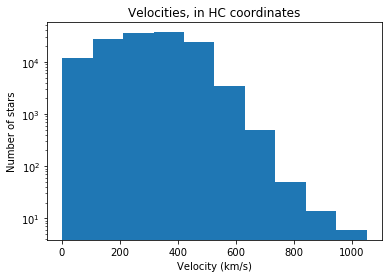

The velocity dispersion is 130.97341234977984 km/s.


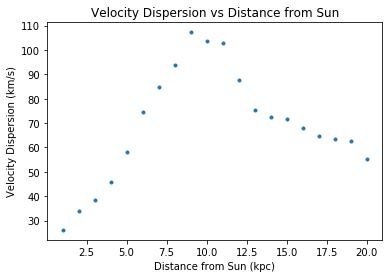

In [7]:
#calculate the magnitude of the velocity vector in HC coordinates
velocityHC = []
for i in np.arange(len(HCxvel)):
    velocityHC.append(np.sqrt(HCxvel[i]**2 + HCyvel[i]**2 + HCzvel[i]**2))
    
plt.hist(velocityHC)
plt.xlabel("Velocity (km/s)")
plt.ylabel("Number of stars")
plt.yscale('log')
plt.title("Velocities, in HC coordinates")
plt.show()
sigmaHC = np.std(velocityHC)
print("The velocity dispersion is " + repr(sigmaHC) + " km/s.")

radiusHC = []
for i in np.arange(len(HCx)):
    radiusHC.append(np.sqrt(HCx[i]**2 + HCy[i]**2 + HCz[i]**2))

radiusHC = np.array(radiusHC)
velocityHC = np.array(velocityHC)

#calculate velocity dispersion as a function of distance from the Sun
dataarray = [[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]]
for i in np.arange(20):
    velocities = velocityHC[(radiusHC > i) & (radiusHC <= i + 1)]
    dataarray[i] = np.std(velocities)
radialdist = np.arange(1,21)
plt.plot(radialdist, dataarray, '.')
plt.xlabel("Distance from Sun (kpc)")
plt.ylabel("Velocity Dispersion (km/s)")
plt.title("Velocity Dispersion vs Distance from Sun")
plt.show()